# Fitting psychometric functions

This notebook analyzes data from `Pilot 11` dataset.

In [1]:
library(data.table)
library(ggplot2)        

## Dataset handling

Let's load and inspect the dataset.

In [2]:
# load dataset
data <- fread('../../data/Pilot11/psychophysical_data.csv')
data[,presenceCP:=as.factor(presenceCP)]
data[,choice:=as.factor(choice)]

In [5]:
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [6]:
str(data)

Classes ‘data.table’ and 'data.frame':	476 obs. of  10 variables:
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 1 1 1 1 1 1 2 2 2 2 ...
 $ correct        : logi  TRUE TRUE TRUE FALSE TRUE FALSE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 2 1 2 2 2 1 1 1 1 ...
 $ viewingDuration: num  0.5 0.4 0.2 0.5 0.4 0.5 0.4 0.5 0.1 0.3 ...
 $ signedCoherence: int  -60 NA -60 NA NA NA 12 12 -12 0 ...
 $ coherence      : int  60 24 60 12 12 12 12 12 12 0 ...
 $ choice_time    : num  0.921 0.86 1.125 0.875 0.979 ...
 $ exactVD        : num  0.525 0.424 0.203 0.525 0.407 ...
 $ signedCohLast  : int  -60 -24 -60 12 -12 12 12 12 -12 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
head(data)

validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,signedCohLast
1,left,TRUE,no,0.5,-60,60,0.9206421,0.5248945,-60
2,left,TRUE,yes,0.4,NA,24,0.8598706,0.4237288,-24
3,left,TRUE,no,0.2,-60,60,1.1245399,0.2033898,-60
4,left,FALSE,yes,0.5,NA,12,0.8751249,0.5254237,12
5,left,TRUE,yes,0.4,NA,12,0.9794417,0.4067797,-12
6,left,FALSE,yes,0.5,NA,12,1.1367451,0.5073636,12


## Simple fits

We start super simple with the equation:
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x$ is the signed coherence value.

In [10]:
logistic_fit_1 <- glm(choice ~ signedCohLast, family=binomial(), data=data)


Call:
glm(formula = choice ~ signedCohLast, family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9927  -0.8902   0.5435   0.9513   1.6392  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.558294   0.105590   5.287 1.24e-07 ***
signedCohLast 0.026656   0.003156   8.445  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.16  on 475  degrees of freedom
Residual deviance: 548.44  on 474  degrees of freedom
AIC: 552.44

Number of Fisher Scoring iterations: 3


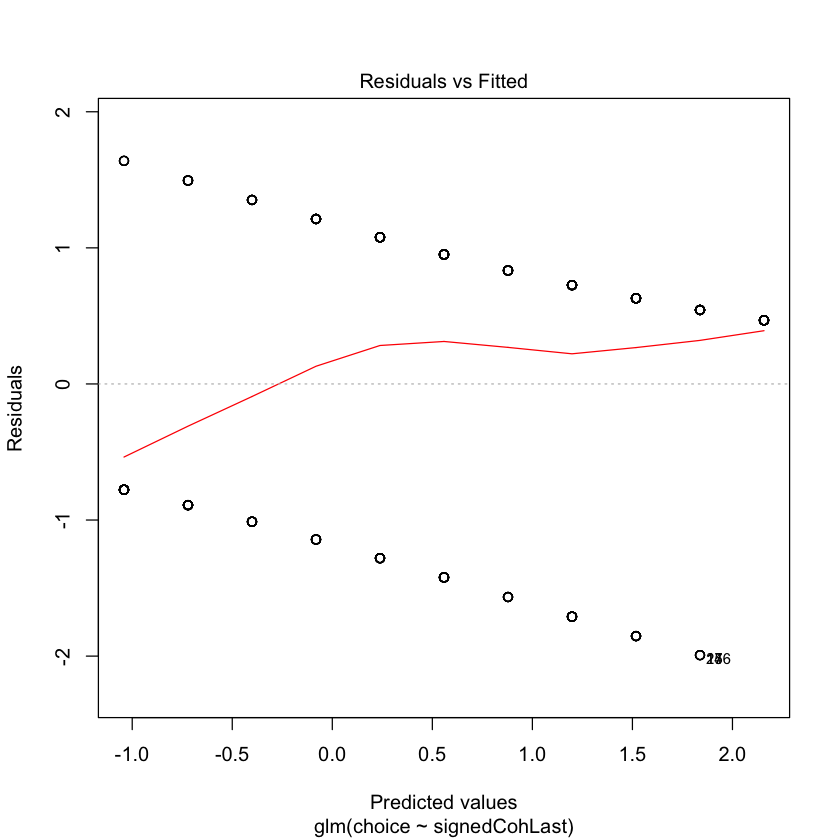

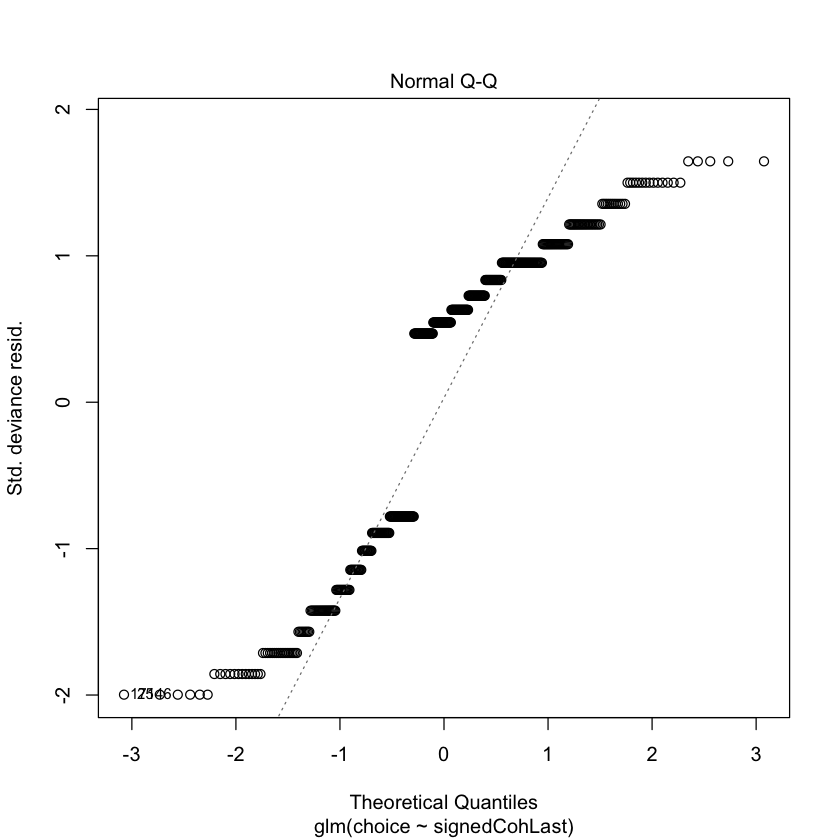

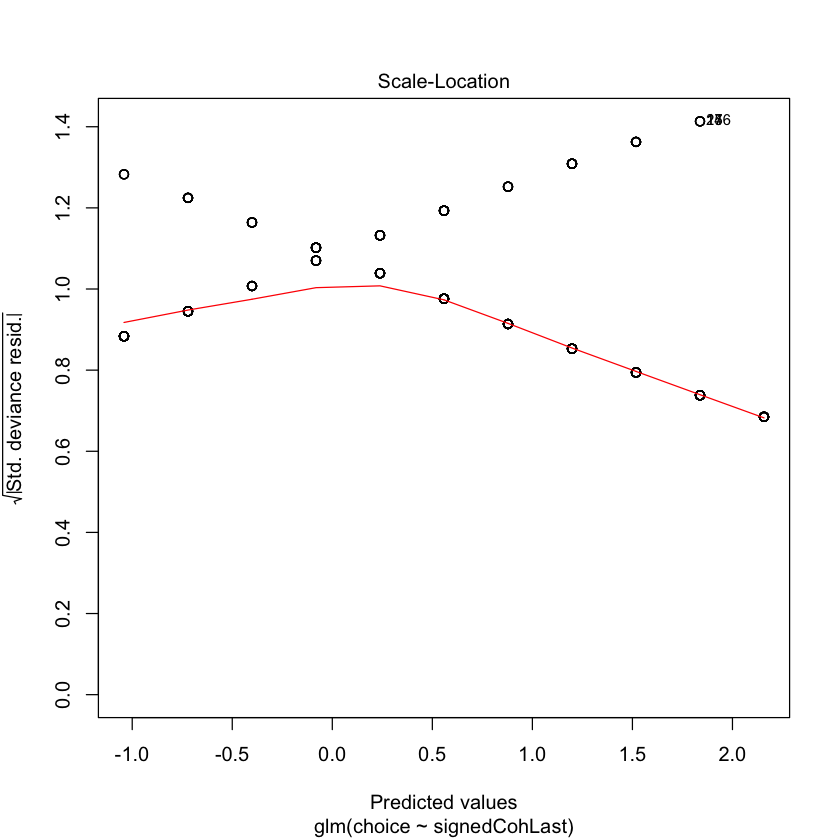

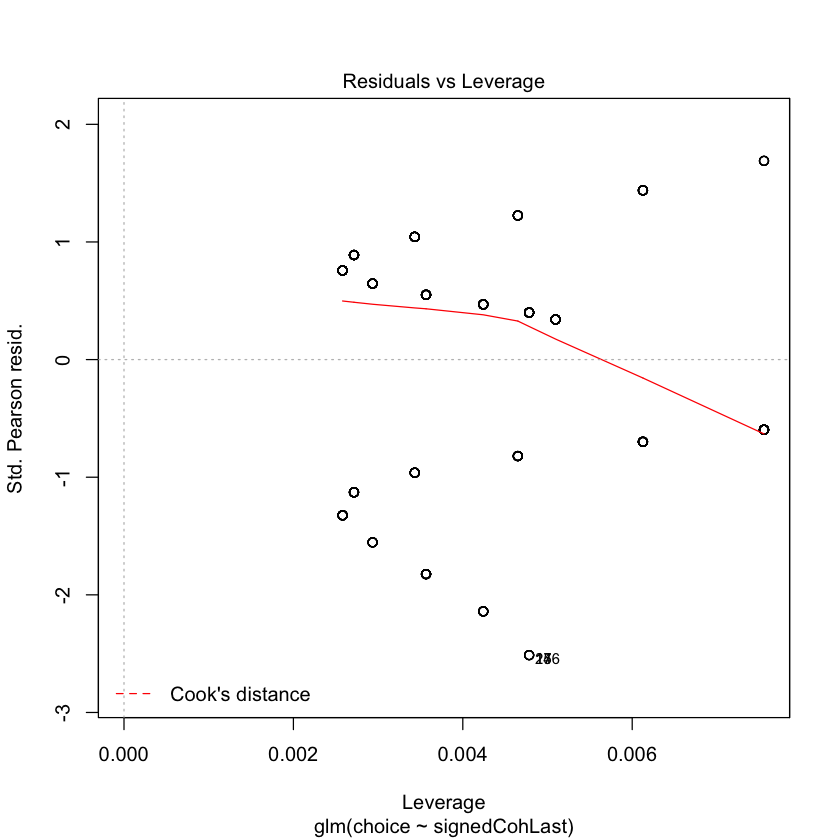

In [11]:
summary(logistic_fit_1)
plot(logistic_fit_1)

## With `quickpsy` package

In [5]:
# for an explanation of masked objects, see here:
# https://stackoverflow.com/a/39137111
library(quickpsy)

Loading required package: DEoptim
Loading required package: parallel

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘quickpsy’

The following object is masked from ‘package:stats’:

    deviance



In [17]:
# let's set presenceCP as factor variable in a temporary data.table before upcoming grouping
tmp <- data[,`:=`(presenceCP=as.factor(presenceCP))]

# build data.table used by the quickpsy package
psychometric <- tmp[, 
                    .(numCorrect=sum(correct), N=.N), 
                    by=.(coherence, viewingDuration, presenceCP)]
psychometric[coherence==0, numCorrect:=as.integer(N/2)]
str(psychometric)

Classes ‘data.table’ and 'data.frame':	48 obs. of  5 variables:
 $ coherence      : int  60 24 60 12 12 12 12 12 0 24 ...
 $ viewingDuration: num  0.5 0.4 0.2 0.5 0.4 0.4 0.5 0.1 0.3 0.2 ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 2 1 2 2 1 1 1 1 1 ...
 $ numCorrect     : int  8 6 16 5 3 7 5 8 6 6 ...
 $ N              : int  8 8 17 11 7 9 7 16 12 19 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "index")= atomic  
  ..- attr(*, "__coherence")= int  9 19 22 29 31 34 35 39 4 5 ...


$$\psi(x)=\gamma + (1-\gamma-\lambda) * F(x)$$
where $\gamma$ is the guess rate, $\lambda$ is the lapse rate and $F$ is a sigmoidal-shape function with asymptotes at 0 and 1.

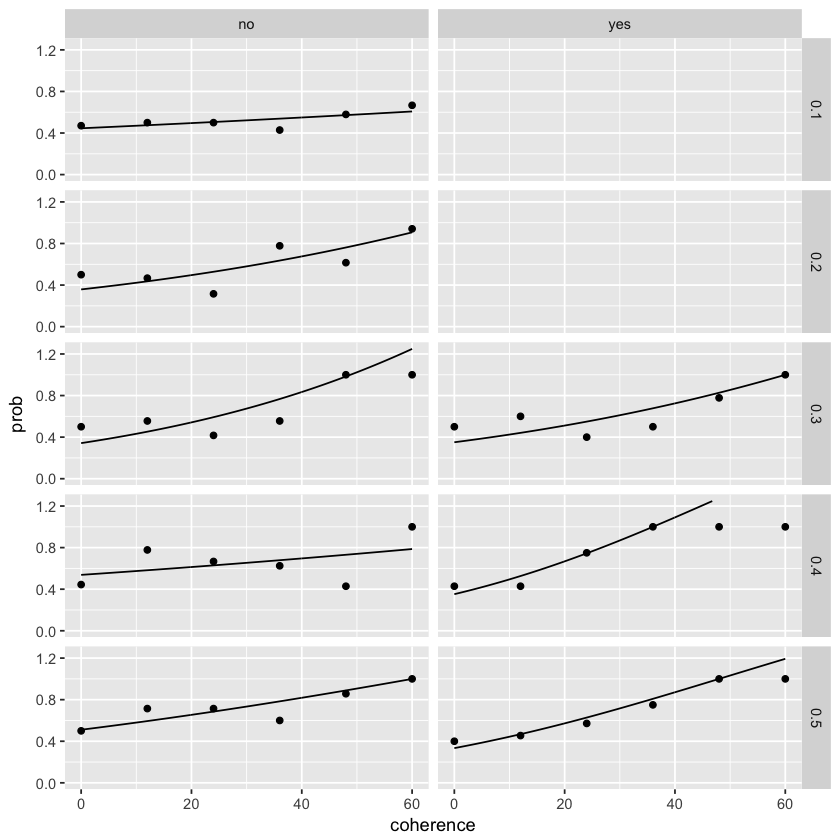

In [18]:
fitWithLapses <- quickpsy(psychometric, 
                          coherence, 
                          numCorrect, N,
                          grouping = c(viewingDuration, presenceCP), lapses  = T, bootstrap = 'none') 

ggplot() +
  facet_grid(viewingDuration~presenceCP) +
  geom_point(data = fitWithLapses$averages, 
             aes(x = coherence, y = prob)) +
  geom_line(data = fitWithLapses$curves, 
            aes(x = x, y = y)) +
  ylim(0, 1.25) # we include ggplot ylim to be able to visualize what is going on

In [19]:
# perform the fits
# ref here:
# http://dlinares.org/lapsesquickpsy.html
fit <- quickpsy(psychometric, coherence, numCorrect, N, grouping = .(viewingDuration, presenceCP),
               log=FALSE, fun=logistic_fun, lapses=TRUE, bootstrap="nonparametric")

In [20]:
str(fit)

List of 33
 $ x                   : chr "coherence"
 $ k                   : chr "numCorrect"
 $ n                   : chr "N"
 $ guess               : num 0
 $ lapses              : logi TRUE
 $ averages            :Classes ‘grouped_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	48 obs. of  6 variables:
  ..$ coherence      : int [1:48] 60 24 60 12 12 12 12 12 0 24 ...
  ..$ viewingDuration: num [1:48] 0.5 0.4 0.2 0.5 0.4 0.4 0.5 0.1 0.3 0.2 ...
  ..$ presenceCP     : Factor w/ 2 levels "no","yes": 1 2 1 2 2 1 1 1 1 1 ...
  ..$ numCorrect     : int [1:48] 8 6 16 5 3 7 5 8 6 6 ...
  ..$ N              : int [1:48] 8 8 17 11 7 9 7 16 12 19 ...
  ..$ prob           : num [1:48] 1 0.75 0.941 0.455 0.429 ...
  ..- attr(*, ".internal.selfref")=<externalptr> 
  ..- attr(*, "index")= atomic (0) 
  .. ..- attr(*, "__coherence")= int [1:48] 9 19 22 29 31 34 35 39 4 5 ...
  ..- attr(*, "vars")= chr [1:2] "viewingDuration" "presenceCP"
  ..- attr(*, "drop")= logi TRUE
  ..- attr(*, "indices")=List of 8
 

Warning message:
“Removed 2 rows containing missing values (geom_linerange).”Warning message:
“Removed 6 rows containing missing values (geom_errorbarh).”

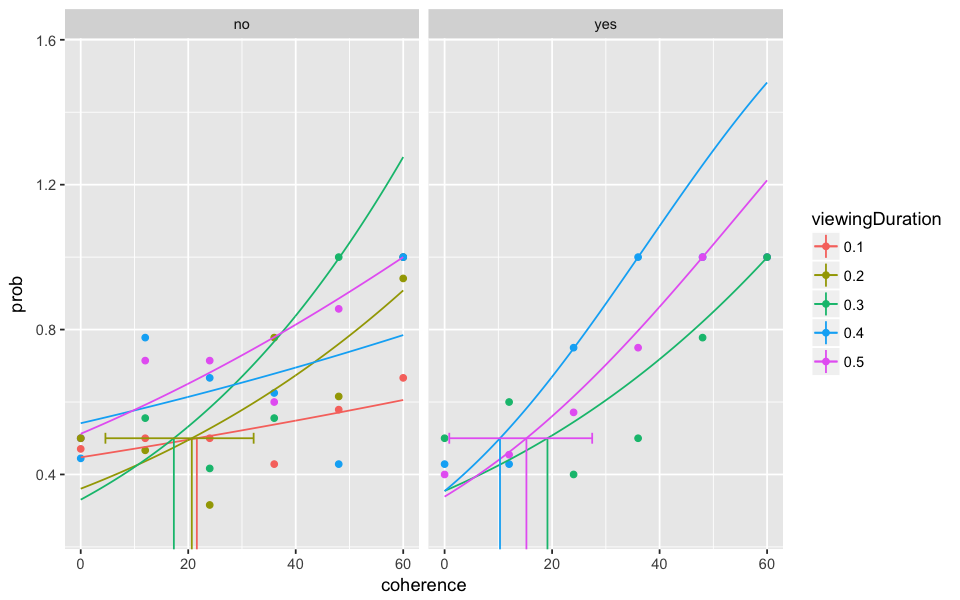

In [24]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
plot(fit) + xlim(c(0,60))

Warning message:
“Ignoring unknown aesthetics: fill”

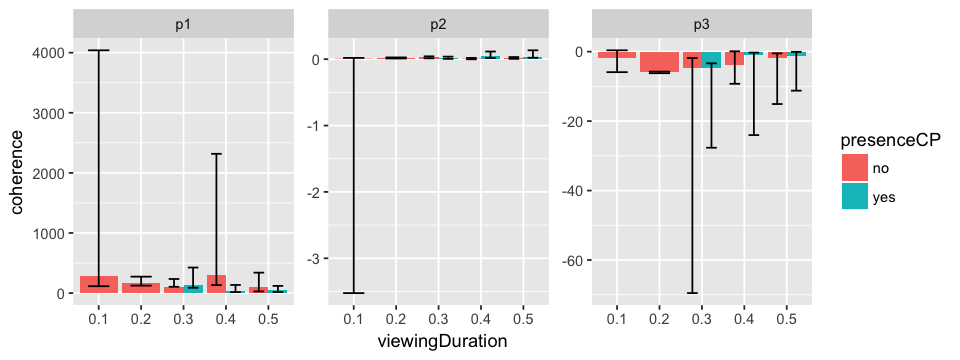

In [26]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=3)
plotpar(fit) #+ ylim(c(0,.25))

Warning message:
“Ignoring unknown aesthetics: fill”Warning message:
“Removed 3 rows containing missing values (geom_errorbar).”

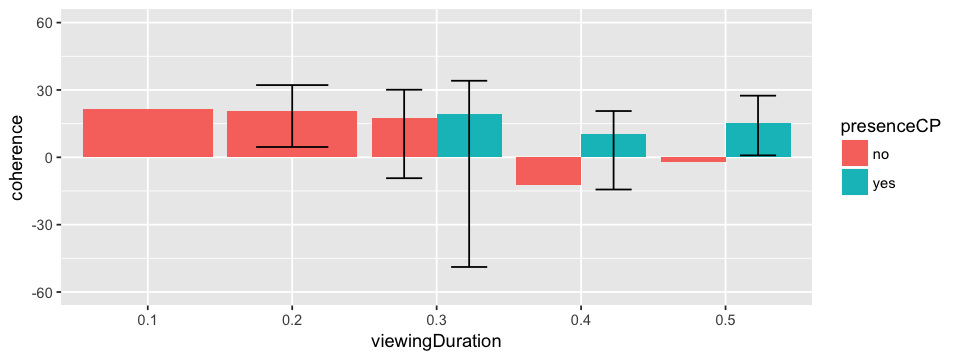

In [32]:
plotthresholds(fit) + ylim(c(-60,60))


## With `glm` function

In [ ]:
# psychometric[,numChooseLeft := N - numChooseRight]
# str(psychometric)

In [ ]:
# # let's first follow this example:
# # http://www.dlinares.org/psychopract.html#fitting-using-generalized-linear-models
# model <- glm( cbind(numChooseRight, numChooseLeft) ~ signedCoherence, 
#              data= psychometric, 
#              family = binomial(probit))

# xseq <- seq(-60, 60, 1)
# yseq <- predict(model, data.frame(signedCoherence = xseq), type = 'response')
# curve <- data.frame(xseq, yseq)

# p <- ggplot() +
#   geom_point(data = psychometric[,.(signedCoherence, chooseRight=numChooseRight / N)], 
#              aes(x = signedCoherence, y = chooseRight)) +
#   geom_line(data = curve,aes(x = xseq, y = yseq))
# p

The problem here is that I have a single regressor, namely, `signedCoherence`. This is not what I want.

In [ ]:
# Try instead this example
#https://www.statmethods.net/advstats/glm.html
# with good interpretation here:
# https://stats.idre.ucla.edu/r/dae/logit-regression/

In [16]:
fit2 <- glm(choice ~ signedCoherence * log(exactVD) + presenceCP, data = data, family=binomial())

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [15]:
summary(fit2)


Call:
glm(formula = choice ~ coherence * log(exactVD) + presenceCP, 
    family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7498  -1.2769   0.8322   0.9972   1.3359  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)
(Intercept)             0.170442   0.468922   0.363    0.716
coherence              -0.014353   0.011945  -1.202    0.230
log(exactVD)           -0.488535   0.335091  -1.458    0.145
presenceCPyes           0.337527   0.246836   1.367    0.171
coherence:log(exactVD) -0.000292   0.008849  -0.033    0.974

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.16  on 475  degrees of freedom
Residual deviance: 620.36  on 471  degrees of freedom
AIC: 630.36

Number of Fisher Scoring iterations: 4


In [ ]:
confint(fit2) # 95% CI for the coefficients, using profiled log-likelihood
confint.default(fit2)  # CIs using standard errors

In [ ]:
# odds ratios and 95% CI
exp(cbind(OddsRatio = coef(fit2), confint(fit2)))

In [ ]:
library("aod")
wald.test(b = coef(fit2), Sigma = vcov(fit2), Terms = 4)

In [ ]:
# better to use this
# https://stats.idre.ucla.edu/r/dae/logit-regression/
predict(fit2, type="response") # predicted values
residuals(fit2, type="deviance") # residuals

In [ ]:
cdplot(choice~signedCoherence, data=tmp_glm) 

In [ ]:
cdplot(choice~viewingDuration, data=tmp_glm) 

In [ ]:
# now try this
#https://datascienceplus.com/perform-logistic-regression-in-r/